---
author: Mauricio Alejandro Prieto Palacios
title: Best recipes prediction
categories: [news, code, analysis]
image: "UNKNOWN.jpeg"
format:
    html:
        theme: pulse
        toc: true
        code-fold: true
        code-tools: true 
        highlight-style: arrow
        toc-title: Contents
        anchor-sections: true
        link-external-icon: true
        code-block-bg: false
        code-block-border-left: "#31BAE9" 
        embed-resources: true
        fig-align: center
        
---

In [231]:
from pathlib import Path

import missingno as msno
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, make_scorer, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [232]:
my_palette = ['#3C7E00', '#D9B100', '#EC5800', '#003153', '#70778C'] * 2
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(my_palette))

In [233]:
plot_name = {
    'calories': 'Calories',
    'carbohydrate': 'Carbohydrate',
    'sugar': 'Sugar',
    'protein': 'Protein',
    'category': 'Category',
    'servings': 'Servings',
    'high_traffic': 'High traffic'
}

In [234]:
recipes = pd.read_csv(Path('data') / 'recipe_site_traffic_2212.csv')
recipes

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


In [235]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [236]:
recipes.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


The dataset has several missing values. The number of missing values and its proportion per each variable is:

In [237]:
recipes.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [238]:
recipes.isna().mean()

recipe          0.000000
calories        0.054910
carbohydrate    0.054910
sugar           0.054910
protein         0.054910
category        0.000000
servings        0.000000
high_traffic    0.393875
dtype: float64

## Data Validation

### `recipe`
The column `recipe` is the ID of the recipe. It is unique and has the same number of unique values as the number of rows in the dataset. So, it can be removed.

In [239]:
assert recipes['recipe'].min() >= 1
assert recipes['recipe'].is_unique
assert recipes['recipe'].nunique() == len(recipes)
recipes.drop(columns='recipe', inplace=True)

### `calories`, `carbohydrate`, `sugar`, `protein`
These are some numeric columns with missing values.

In [240]:
nutrition_columns = ['calories', 'carbohydrate', 'sugar', 'protein']

In [241]:
recipes[nutrition_columns].describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


The minima are greater than zero, and the maxima are huge. Calories is the most spread variable. I will address the missing values right away, since it is the most important problem.

### Missing values

The columns have missing values in exactly the same observations! Only `high_traffic` has a different number of missing values.

<Axes: >

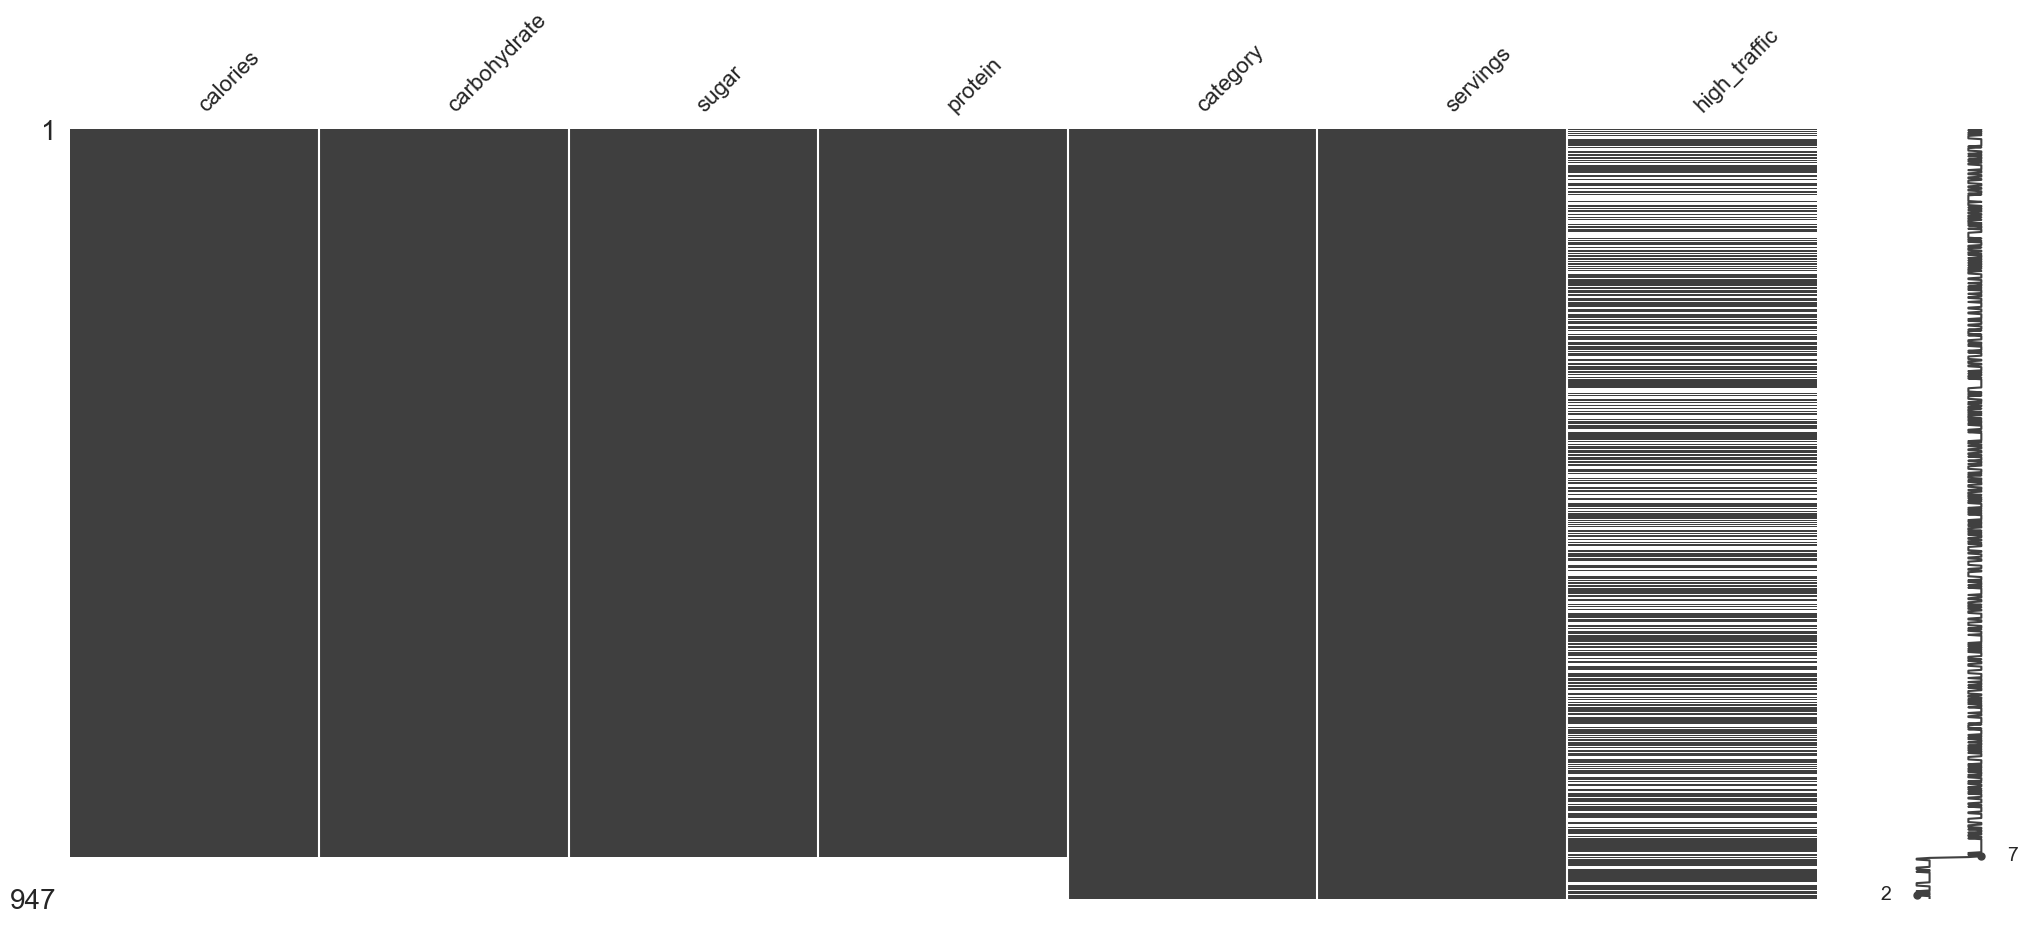

In [242]:
msno.matrix(recipes.sort_values('calories'))

We have Missing Not at Random (MNAR), because the existence of missing values in the columns is perfectly correlated:

<Axes: >

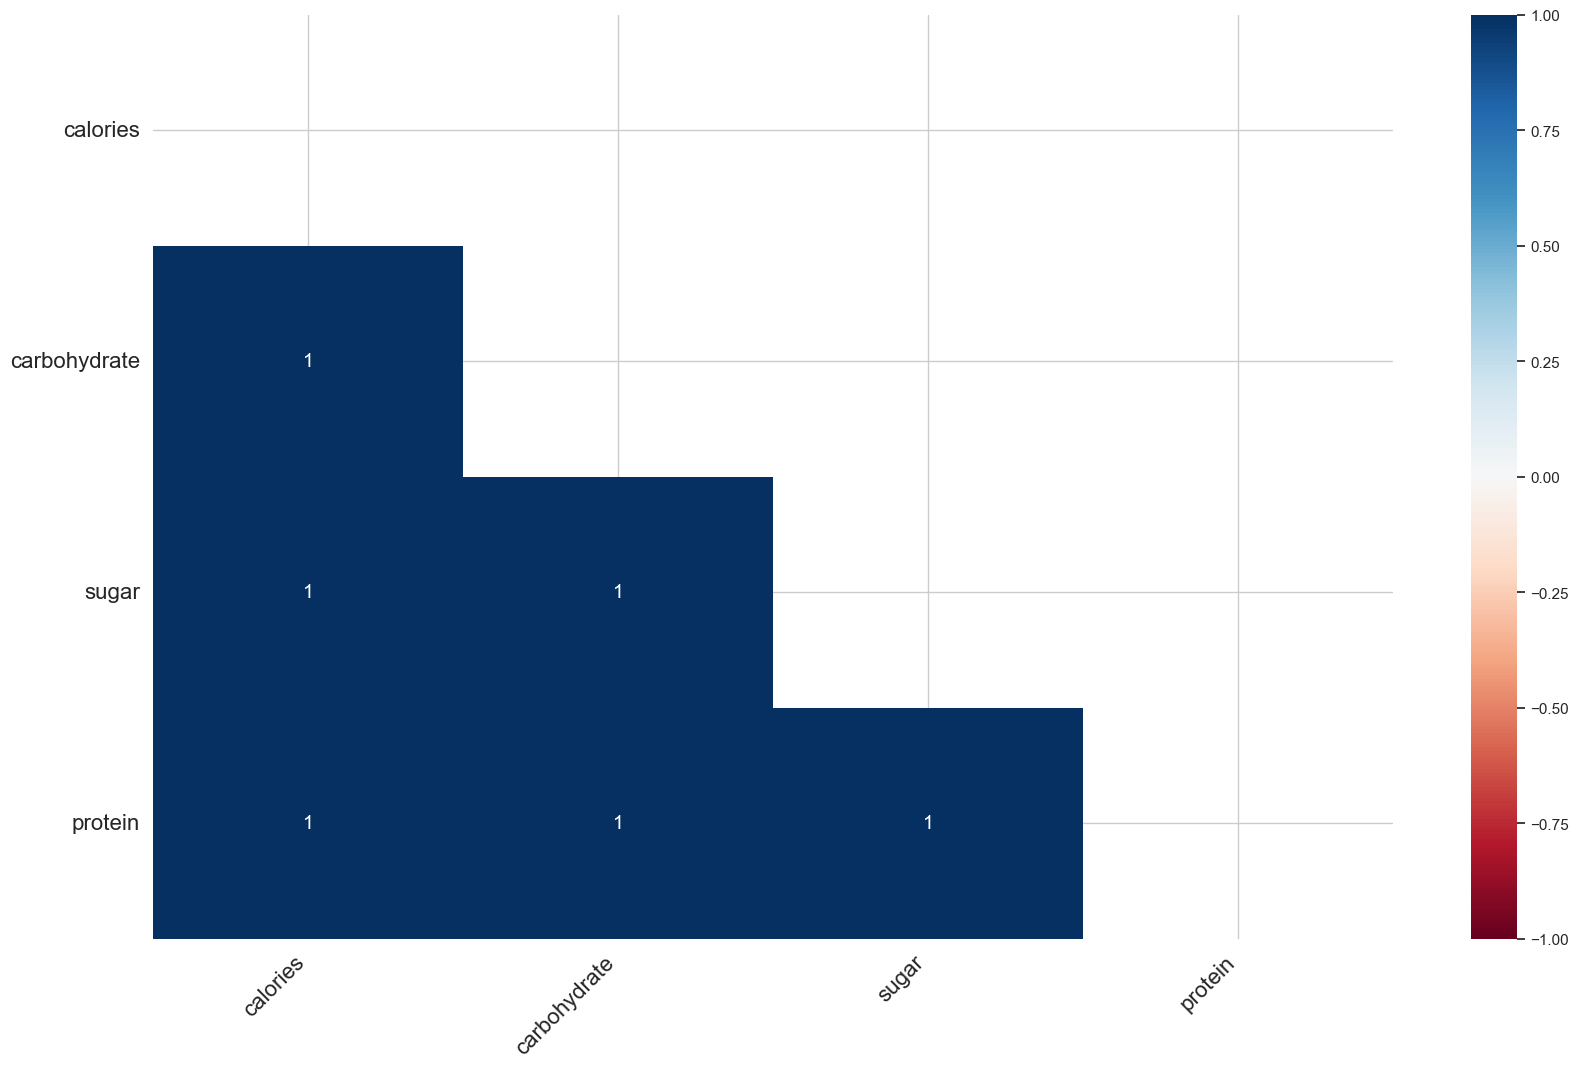

In [243]:
msno.heatmap(recipes[nutrition_columns])

It is possible that it was a problem in the collection process: perhaps these recipes were not correctly extracted from the database. I prefer talk with the team responsible for the data collection, but for now I will just remove these observations (around 5% of the data) .

In [244]:
recipes.dropna(subset=nutrition_columns, inplace=True)

### Anomaly detection

In [245]:
def detect_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (series < lower_bound) | (series > upper_bound)

In [246]:
for col in nutrition_columns:
    print(f'Outliers in {col}: {detect_outliers(recipes[col]).sum()}')

Outliers in calories: 47
Outliers in carbohydrate: 58
Outliers in sugar: 79
Outliers in protein: 77


There are outliers in all nutritional columns. In fact, the columns are highly skewed to the right, that is, the skewness is positive and greater than 1:

In [247]:
recipes[nutrition_columns].skew()

calories        2.036151
carbohydrate    3.756980
sugar           4.223352
protein         3.509453
dtype: float64

array([[<Axes: title={'center': 'calories'}>,
        <Axes: title={'center': 'carbohydrate'}>],
       [<Axes: title={'center': 'sugar'}>,
        <Axes: title={'center': 'protein'}>]], dtype=object)

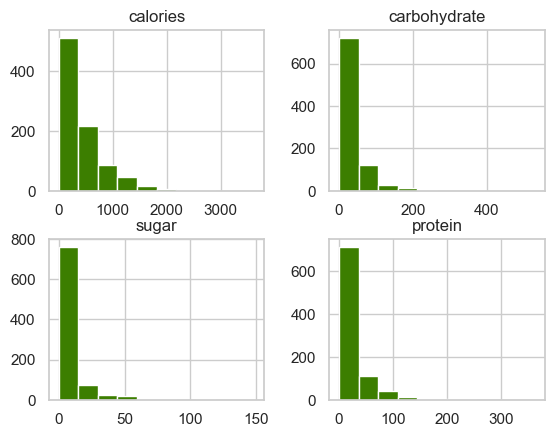

In [248]:
recipes[nutrition_columns].hist()

<Axes: >

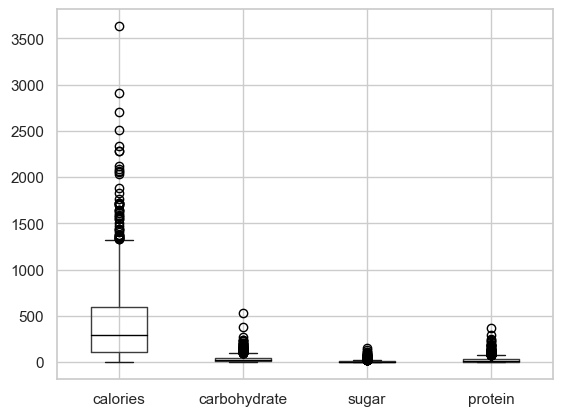

In [249]:
recipes[nutrition_columns].boxplot()

The outliers might be actual values, so it is best to discuss with the team to be certain. During the analysis I will keep the outliers, but in the model fit I will control the skewness by log transforming the data, as shown here:

array([[<Axes: title={'center': 'calories'}>,
        <Axes: title={'center': 'carbohydrate'}>],
       [<Axes: title={'center': 'sugar'}>,
        <Axes: title={'center': 'protein'}>]], dtype=object)

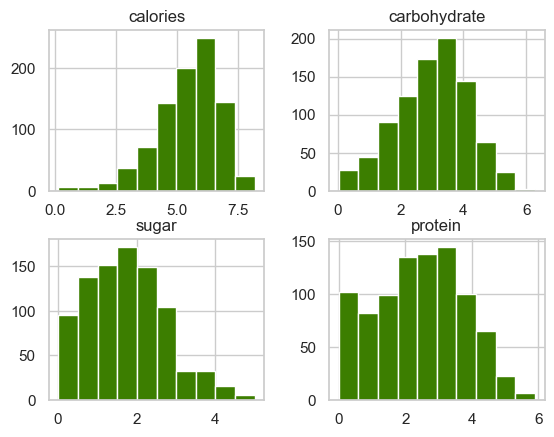

In [250]:
np.log(recipes[nutrition_columns] + 1).hist()

### `category`
There are 10 possible groups of recipes. Nevertheless, I found 11 unique values in the column.

In [251]:
recipes['category'].value_counts()

category
Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: count, dtype: int64

The value `Chicken Breast` is a typo of `Chicken`. I will replace it.

In [252]:
recipes['category'] = (recipes['category']
                       .replace({'Chicken Breast': 'Chicken'})
                       .astype('category'))
recipes['category'].value_counts()

category
Chicken          163
Breakfast        106
Beverages         92
Potato            83
Lunch/Snacks      82
Vegetable         78
Dessert           77
Meat              74
Pork              73
One Dish Meal     67
Name: count, dtype: int64

### `servings`

In [253]:
recipes['servings'].value_counts()

servings
4               365
6               184
2               174
1               169
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

I will remove unnecessary characters and convert to numeric data type.

In [254]:
recipes['servings'] = recipes['servings'].str.replace(r'\D+', '', regex=True).astype(int)
recipes['servings'].value_counts()

servings
4    367
6    185
2    174
1    169
Name: count, dtype: int64

### `high_traffic`

In [255]:
recipes['high_traffic'].value_counts()

high_traffic
High    535
Name: count, dtype: int64

The missing values correspond to recipes that do not have high traffic, so I will impute and convert to categorical for ease of analysis (in modelling I will encode them properly).

In [256]:
recipes['high_traffic'] = (recipes['high_traffic']
                           .replace({'High': 'Yes'})
                           .fillna('No')
                           .astype('category')
                           .cat.reorder_categories(['Yes', 'No'])
                           )
recipes['high_traffic'].value_counts()

high_traffic
Yes    535
No     360
Name: count, dtype: int64

### Summary
- `recipe`: id of the recipe, unique and sequential, was removed
- `calories`, `carbohydrate`, `sugar`. `protein` : nearly 5% of the data was removed due to missing values, the columns are skewed to the right and have outliers, I will log transform the data in the model fit. The minima were greater than zero as expected.
- `category`: there was a typo in the category `Chicken Breast`, I replaced it. The column was converted to categorical. All the other ten categories are correct: Lunch/Snacks, Beverages, Potato, Vegetable, Meat, Chicken, Pork, Dessert, Breakfast and One Dish Meal.
- `servings`: there were some spelling problems that I quickly fix, no information loss.
- `high_traffic`: the missing values correspond to recipes that do not have high traffic, so I imputed and converted to categorical.

## Data Analysis
There are quite a few variables, so I will analyse them separately depending on their type. 

### Discrete variables

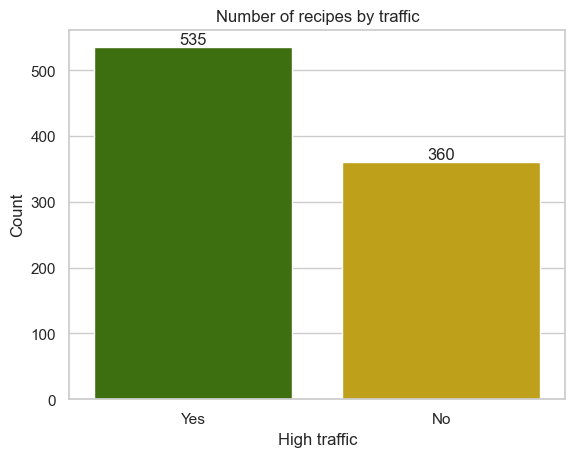

In [257]:
plot_traffic = sns.countplot(data=recipes, x='high_traffic')
plot_traffic.bar_label(plot_traffic.containers[0])
plot_traffic.set(xlabel=plot_name['high_traffic'],
                 ylabel='Count',
                 title='Number of recipes by traffic')
plot_traffic.figure.savefig("im/traffic.png")

The target variable is unbalanced, recipes with high traffic are more frequent.

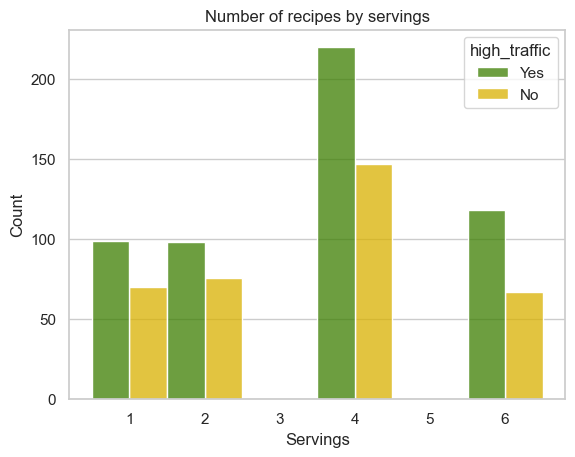

In [264]:
plot_traffic_servings = sns.histplot(data=recipes,
                                     x='servings',
                                     hue='high_traffic',
                                     discrete=True,
                                     multiple='dodge')
plot_traffic_servings.grid(axis='x')
plot_traffic_servings.set(xlabel=plot_name['servings'],
                          ylabel='Count',
                          title='Number of recipes by servings')
plot_traffic_servings.figure.savefig("im/traffic_servings.svg")

Recipes with 4 servings are the most popular, so the main customers might be families. Get to know the customers better would be interesting to understand the traffic on the website!
On the other hand, there are no recipes with 3 nor 5 servings. Why do not we offer recipes with these servings? 

The different categories have a different number of recipes. So, I will show the proportion of recipes with high traffic in each category.

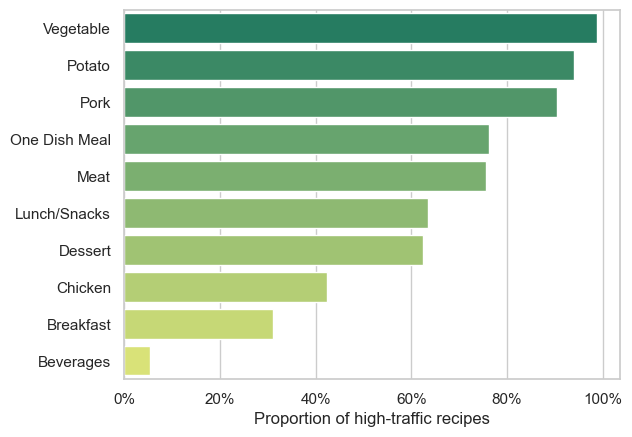

In [230]:
traffic_by_category = (
    recipes
    .groupby('category')['high_traffic']
    .value_counts(normalize=True, sort=True)
    .unstack()[['Yes']]
    .reset_index()
)
plot_percent = sns.barplot(traffic_by_category,
                           x='Yes',
                           y='category',
                           palette='summer',
                           #palette=my_palette[2:3],
                           order=traffic_by_category.sort_values('Yes', ascending=False)['category']
                           )
plot_percent.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot_percent.set(xlabel='Proportion of high-traffic recipes',
                 #title='Proportion of high-traffic recipes by category',
                 ylabel=''
                 )
plot_percent.figure.savefig("im/traffic_category.svg")


The more popular categories are by far `Vegetable` and `Potato`. The less popular is `Beverages`. It seems that people prefer to search for healthy recipes.

### Continuous variables

[Text(0.5, 0, 'Calories'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of calories')]

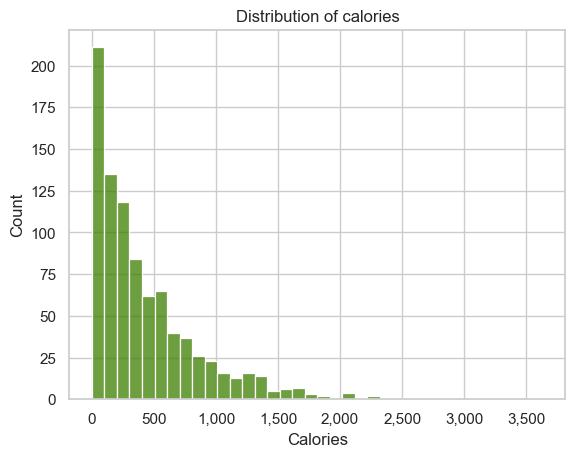

In [176]:
plot_calories = sns.histplot(data=recipes, x='calories')
plot_calories.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
plot_calories.set(xlabel=plot_name['calories'],
                  ylabel='Count',
                  title='Distribution of calories')

The distribution is highly skewed to the right and there are outliers. Besides, a lot of recipes are low in calories (those in the `vegetable` category).

[Text(0.5, 0, 'Calories'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of calories by popularity')]

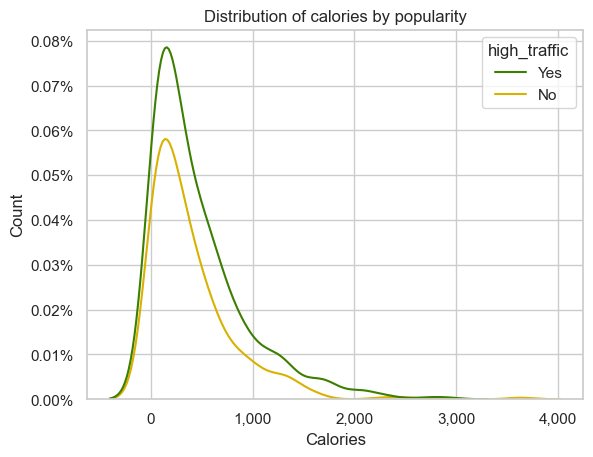

In [177]:
plot_calories_kde = sns.kdeplot(data=recipes, x='calories', hue='high_traffic')
plot_calories_kde.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
plot_calories_kde.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plot_calories_kde.set(xlabel=plot_name['calories'],
                      ylabel='Count',
                      title='Distribution of calories by popularity')

It looks like high-traffic recipes have more calories than low-traffic recipes. But the distributions are quite similar.

[Text(0.5, 0, 'Calories'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Distribution of calories by category')]

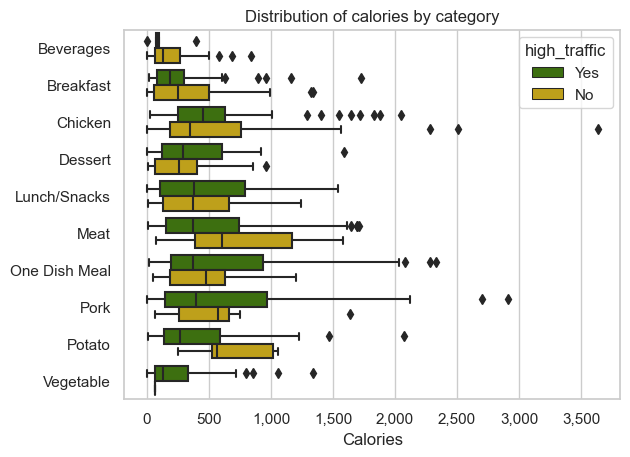

In [178]:
plot_calories_box = sns.boxplot(data=recipes,
                                x='calories',
                                y='category',
                                hue='high_traffic')
plot_calories_box.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
plot_calories_box.set(xlabel=plot_name['calories'],
                      ylabel='',
                      title='Distribution of calories by category')

The distribution of calories is different for each category. Beverages and vegetables have less calories, while meat and pork present more calories, as expected. Additionally, high-traffic recipes do not behave very differently from low-traffic recipes.

The other continuous variables behave similarly, so it is time to move on to review the relationships between the variables.

### Relationships

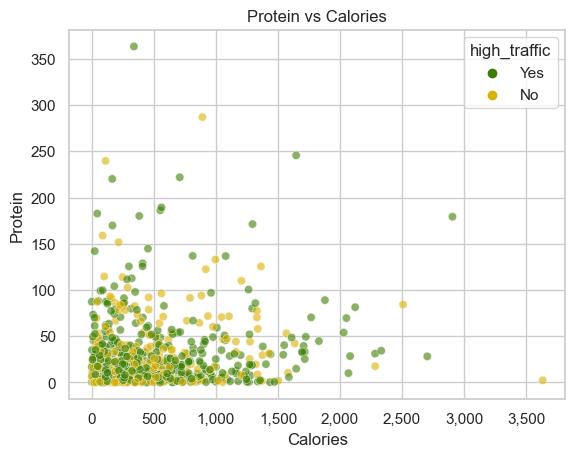

In [266]:
plot_calories_protein = sns.scatterplot(data=recipes,
                                        x='calories',
                                        y='protein',
                                        alpha=0.6,
                                        hue='high_traffic')
plot_calories_protein.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
plot_calories_protein.set(xlabel=plot_name['calories'],
                          ylabel=plot_name['protein'],
                          title=plot_name['protein'] + ' vs ' + plot_name['calories'])

plot_calories_protein.figure.savefig("im/scatter.svg")

Calories and protein do not exhibit a linear relationship and do not effectively separete high-traffic recipes from low-traffic recipes.
Numeric variables might not be enough to explain the traffic, but hypothesis test will help to determine it. But before, it is important to check the relationship between all the numeric variables.

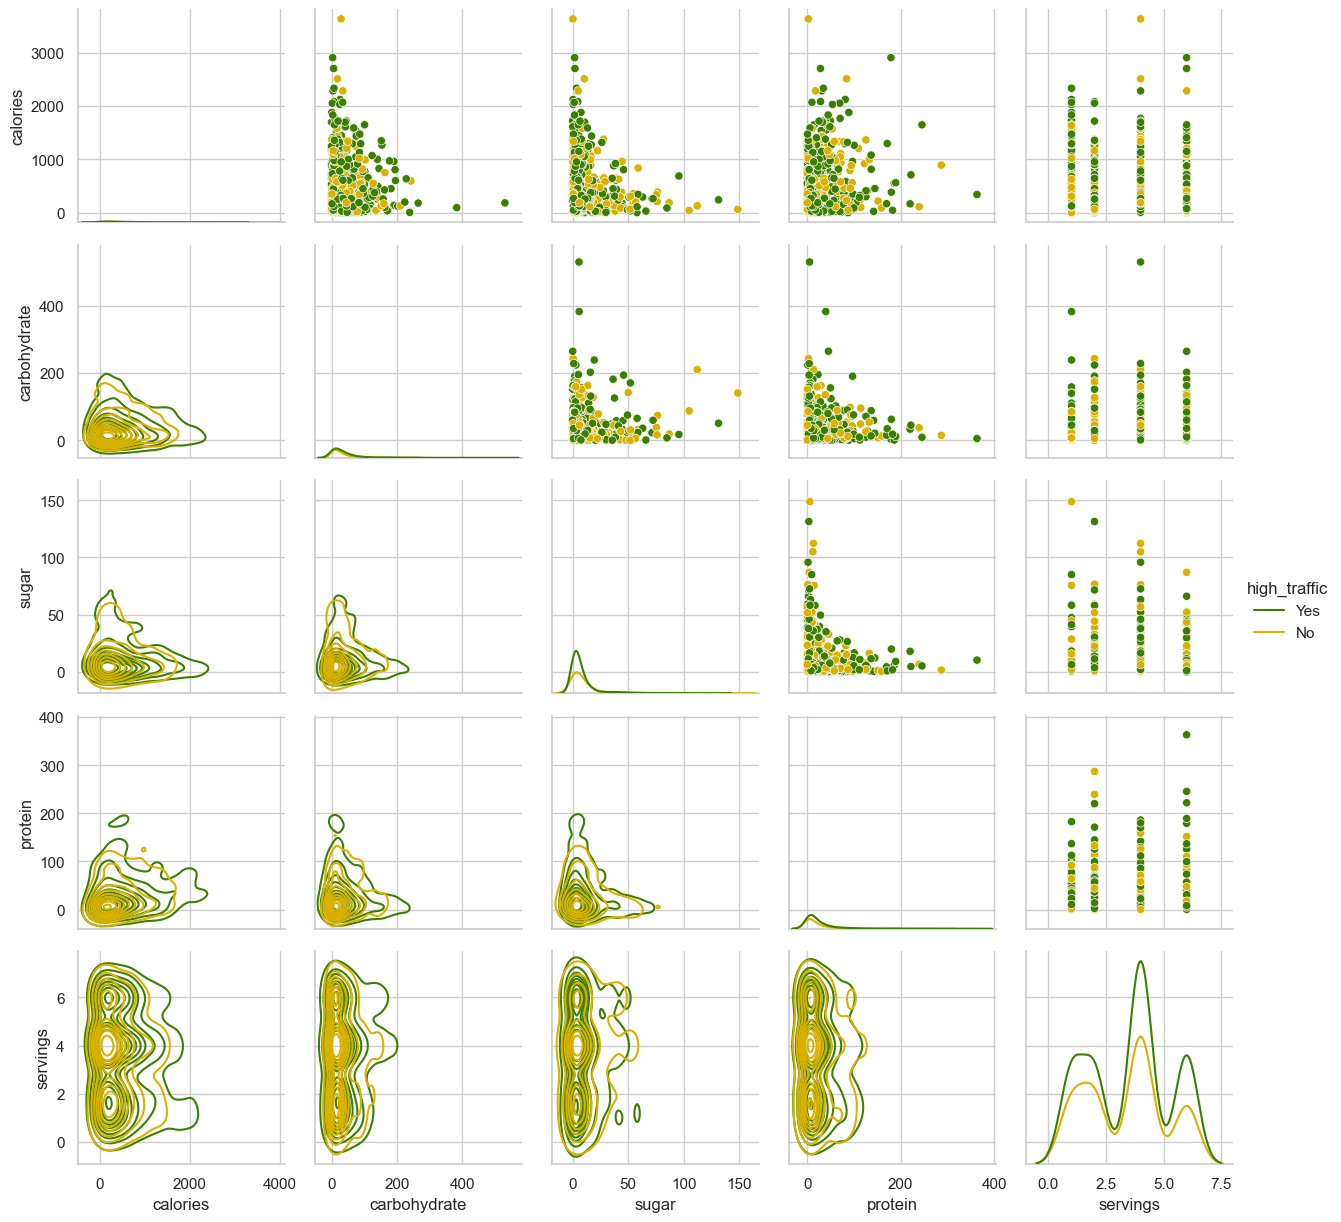

In [180]:
g = sns.PairGrid(recipes, hue='high_traffic')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()

- There are not linear relationships between the variables.
- `servings` is the unique variable that seems to separate high-traffic recipes from low-traffic recipes.
- The distribution of the variables is similar to each other.
- Each variable provides different information but it is not enough to explain the target.
- `servings` do not exhibit any interesting relationship with the other variables.

<Axes: >

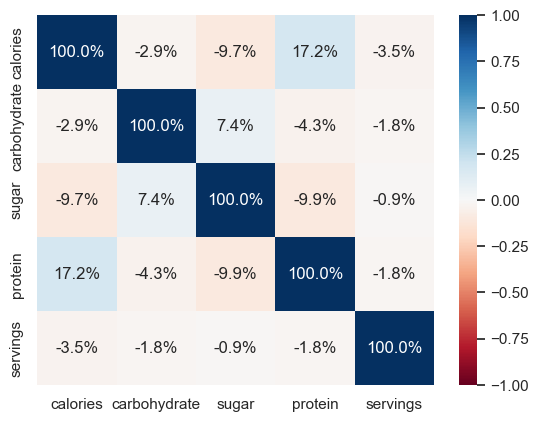

In [181]:
sns.heatmap(recipes.select_dtypes('number').corr(),
            vmin=-1,
            vmax=1,
            annot=True,
            fmt='.1%',
            cmap='RdBu')

The correlation between the variables is low, so it is not necessary to remove any of them. Unfortunately they do not provide enough information to explain the traffic. In consequence, the company should collect new variables.

## Statistical analysis

So far, numeric variables do not provide enough information to explain the target. So, I will perform a hypothesis test to determine if there is a difference in means between high-traffic recipes and low-traffic recipes. I have already examined calories, so I will focus on the other variables.

<Axes: xlabel='value', ylabel='variable'>

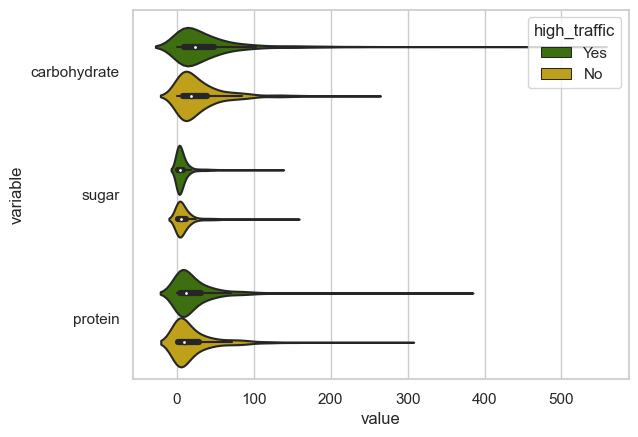

In [215]:
num = recipes.drop(columns=['calories', 'servings', 'category']).melt(id_vars='high_traffic')
sns.violinplot(data=num, y='variable', x='value', hue='high_traffic')

The shape of the distributions is similar for each variable and does not change with the traffic. This suggests that there is not a difference between high-traffic recipes and low-traffic recipes. But I will perform a **t test** to confirm it. It is enough to only consider one variable, so I will choose carbohydrate.

In [183]:
carbohydrate_df = recipes[['carbohydrate', 'high_traffic']].sort_values(by='carbohydrate')
carbohydrate_df['carbohydrate'] = np.log(carbohydrate_df['carbohydrate'])
grouped = carbohydrate_df.groupby('high_traffic')['carbohydrate']

In [184]:
grouped.size()

high_traffic
Yes    535
No     360
Name: carbohydrate, dtype: int64

In [185]:
grouped.mean()

high_traffic
Yes    2.929196
No     2.792631
Name: carbohydrate, dtype: float64

The means are quite close.

In [186]:
grouped.std()

high_traffic
Yes    1.398557
No     1.290192
Name: carbohydrate, dtype: float64

Also, the standard deviations are similar.

[Text(0.5, 0, 'Carbohydrate'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of log-carbohydrate')]

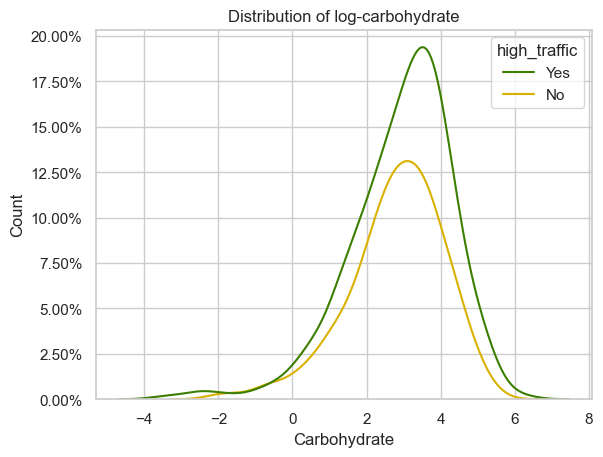

In [187]:
plot_carbohydrate = sns.kdeplot(carbohydrate_df, x='carbohydrate', hue='high_traffic')
plot_carbohydrate.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plot_carbohydrate.set(xlabel=plot_name['carbohydrate'],
                      ylabel='Count',
                      title='Distribution of log-carbohydrate')

After applying the logarithm to stabilize the variance, the distributions are different in their highest points.

In [188]:
def log_transform(col, yes):
    if yes:
        series = recipes[recipes['high_traffic'] == 'Yes'][col]
    else:
        series = recipes[recipes['high_traffic'] == 'No'][col]
    return np.log(series).values


def pvalue(col):
    test = pg.ttest(log_transform(col, yes=True),
                    log_transform(col, yes=False),
                    alternative='two-sided')
    return float(test['p-val'][0])


In [189]:
print(f"The p-value for carbohydrate is {pvalue('carbohydrate'):.2%}")

The p-value for carbohydrate is 13.38%


So, we fail to reject the null hypothesis that the mean of log-carbohydrate is the same for high traffic and low traffic recipes. That is, the evidence is not strong enough to say that both samples come from different distributions.

### PCA

Principal component analysis is used here as a exploratory tool but it may help to posit new predictors.

In [190]:
features = recipes.drop(columns=['category', 'high_traffic'])
exploratory_pipe = make_pipeline(StandardScaler(), PCA())
scores = exploratory_pipe.fit_transform(features)
scores

array([[ 0.65426384, -0.65146186, -0.12452776, -0.8480854 ,  0.18465792],
       [-0.52863982,  1.18388874, -0.77489515, -0.53798623, -1.0438762 ],
       [ 1.80173003, -0.02830077, -0.04476441,  1.38775645, -0.01580786],
       ...,
       [-0.77684631,  0.67283243, -0.49149572, -0.20558992, -0.94864049],
       [ 0.32592996, -1.35255814,  0.7742397 , -0.48519653, -0.12152069],
       [ 0.70429131, -0.38459335,  0.06807003, -0.53266432, -0.06876487]])

In [191]:
loadings = exploratory_pipe.named_steps['pca'].components_
loadings_df = pd.DataFrame(loadings.T,
                           index=features.columns,
                           columns=[f'PCA{i + 1}' for i in range(5)])
loadings_df

,PCA1,PCA2,PCA3,PCA4,PCA5
calories,-0.578795,0.250718,0.222501,0.216261,-0.711239
carbohydrate,0.277938,0.570468,0.657894,-0.401306,0.058704
sugar,0.487713,0.269203,0.067710,0.827178,-0.029301
protein,-0.586355,0.151353,0.238297,0.301640,0.696784
servings,0.077916,-0.718561,0.675499,0.130290,-0.065769


In [192]:
scores_df = pd.DataFrame(data=scores, columns=loadings_df.columns)

[Text(0.5, 1.0, 'Two main PCA by popularity')]

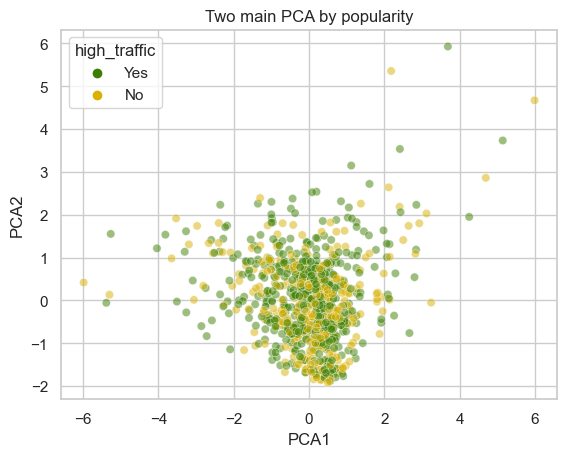

In [193]:
plot_pca = sns.scatterplot(data=scores_df,
                           x='PCA1',
                           y='PCA2',
                           hue=recipes['high_traffic'],
                           alpha=0.5)
plot_pca.set(title='Two main PCA by popularity')

The two main PCA components do not seem to separate the two classes very well.
Even though they are not great predictors, we can still look at the loadings to see which variables are more important in each component and if they provide similar information.

In [194]:
main_pca = loadings_df.iloc[:, :2].reset_index(names='var')
main_pca

,var,PCA1,PCA2
0,calories,-0.578795,0.250718
1,carbohydrate,0.277938,0.570468
2,sugar,0.487713,0.269203
3,protein,-0.586355,0.151353
4,servings,0.077916,-0.718561


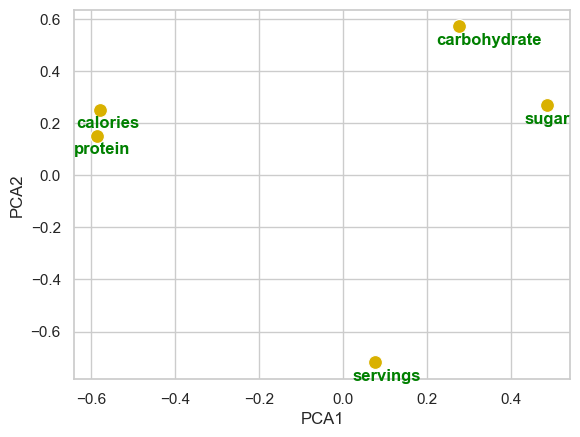

In [195]:
sns.set_palette(sns.color_palette(my_palette[1:2]))
sns.scatterplot(main_pca, x="PCA1", y="PCA2", s=100)
for line in range(main_pca.shape[0]):
    plt.text(main_pca.iloc[line, 1] - 0.055,
             main_pca.iloc[line, 2] - 0.07,
             main_pca.iloc[line, 0],
             horizontalalignment='left',
             color='green',
             size='medium',
             weight='semibold')
plt.show()
sns.set_palette(sns.color_palette(my_palette))

- Calories and protein are the most important variables in the first component and are quite close to each other, so they contain similar information. They can be combined into a single variable.
- Carbohydrate and sugar have a similar behaviour in the second component.
- The first component do not assign a lot of importance to servings, but the second component does. 
- Servings is clearly different from the other predictors and provides new information.

# Modeling

Since the company wants to predict which recipes are popular, it is a supervised learning problem. The target variable is binary, so it is a classification problem.

## Business metrics

- Tasty Bytes desires to correctly predict high traffic recipes 80% of the time: this is the **most important metric**. This means that 8 out of 10 recipes that are predicted to have high traffic should actually have high traffic. This metric is **precision**.
- High-traffic is the important class, so it is the positive class.
- Tasty Bytes also wants to minimize the chance of showing unpopular recipes. In other words, the  low-traffic recipes should be detected as such. This metric is **specificity**.

## Prepare data


Before modeling, I will prepare the data.
- To stabilize the variance, I will apply the logarithm to the numerical variables.
- I will also use one-hot encoding for the categorical variables.
- The target variable will be encoded as 0 and 1.
- The data will be split into train and test sets. The test set will be used only at the end of the modeling process to evaluate the final model, and its size is 20% of the original data.
- The train set will be used for cross-validation and hyperparameter tuning.
- The results will be reproducible by setting a seed with the most simple value, 1 (so, there is no chance of manipulating the final metrics).

In [196]:
features = recipes.drop(columns=['high_traffic'])
features = pd.get_dummies(features, drop_first=True, dtype='int32')
target = recipes['high_traffic'].replace({'Yes': 1, 'No': 0}).astype('int32')

In [197]:
seed = 1
X = np.log(features.values + 1)
y = target.values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=seed)
fold_info = KFold(n_splits=5, shuffle=True, random_state=seed)

Precision and specificity will be used as scoring metrics. The roc auc score is a good option for training because it incorporates information about the two classes.

In [198]:
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)


my_scoring = {'precision': make_scorer(precision_score),
              'roc_auc': make_scorer(roc_auc_score),
              'specificity': make_scorer(specificity)}

## Base model

- Naive Bayes is a simple model that can be used as a baseline.
- It is a good choice for the first model because it is fast and does not require so much hyperparameter tuning.
- Also, I will use PCA to reduce the number of predictors (because of this it is needed to standardize at the beginning).

In [199]:
pipe_naive = make_pipeline(StandardScaler(), PCA(), GaussianNB())
grid = {
    'gaussiannb__var_smoothing': [1e-12, 1e-10, 1e-9, 1e-8]
}
nb = GridSearchCV(pipe_naive,
                  grid,
                  cv=fold_info,
                  scoring=my_scoring,
                  refit='roc_auc',
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=1)
nb.fit(X_train, y_train)
print(nb.best_params_)
print(nb.best_score_) # score is the metric in the parameter `scoring`

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'gaussiannb__var_smoothing': 1e-12}
0.7374247680537823


After hyperparameter tuning, the best model is the one with `var_smoothing=1e-12`. So now I will fit the model with the best hyperparameters and evaluate it with the test set.

In [200]:
print(f"Precision: {precision_score(y_test, nb.predict(X_test)):0.2%} ")
print(f"Specificity: {specificity(y_test, nb.predict(X_test)):0.2%} ")

Precision: 85.29% 
Specificity: 79.17% 


The precision is greater than 85%, which is the desired value. The specificity is close to 80%. So, the model is good enough to be used as a baseline.

In [201]:
cm_nb = confusion_matrix(y_test, nb.predict(X_test), labels=nb.classes_)
cm_nb

array([[57, 15],
       [20, 87]])

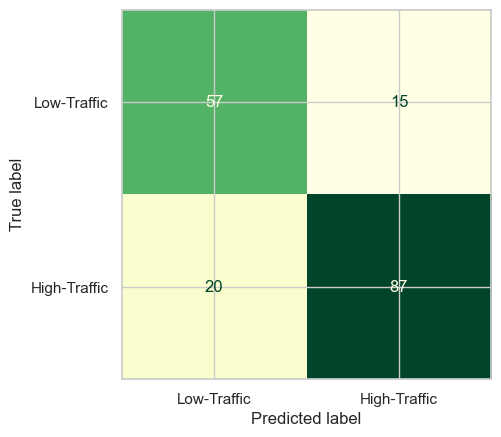

In [223]:
cm_nb = ConfusionMatrixDisplay.from_estimator(nb,
                                              X_test,
                                              y_test,
                                              display_labels=['Low-Traffic', 'High-Traffic'],
                                              cmap='YlGn',
                                              colorbar=False)
cm_nb.figure_.savefig('im/conf_nb.svg')

Confusion matrix is a good way to visualize the results. It shows that the model is predicting more high-traffic recipes than low-traffic recipes. This is good because the most important metric is precision.
Naive bayes performed quite well but it is not the best option to show the most important variables to the business. So, I will try a tree-based model.

## Alternative model

- Random forest is a good option because it is fast and can be used to show the most important variables.
- It does not need preprocessing
- Hyperparameter tuning can help to improve the model.

In [203]:

pipe_rf = make_pipeline(RandomForestClassifier(random_state=seed, n_jobs=-1))
grid = {
    'randomforestclassifier__n_estimators': [5, 10, 50, 100],
    'randomforestclassifier__max_depth': [3, 10, 25],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
}
rf = GridSearchCV(pipe_rf,
                  grid,
                  cv=fold_info,
                  scoring=my_scoring,
                  refit='precision',
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=1)
rf.fit(X_train, y_train)
print(rf.best_params_)
print(rf.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 100}
0.7862318851417894


After hyperparameter tuning, the best model is the one with `criterion='gini'`, `max_depth=3`, `max_features='sqrt'` and `n_estimators=100`.
So now I will fit the model with the best hyperparameters and evaluate it with the test set.

In [204]:
print(f"Precision: {precision_score(y_test, rf.predict(X_test)):0.2%} ")
print(f"Specificity: {specificity(y_test, rf.predict(X_test)):0.2%} ")

Precision: 84.38% 
Specificity: 79.17% 


The precision is close to 85%, which is best than the desired value. The specificity is close to 80%. So, the model is adequate.

In [205]:
cm_rf = confusion_matrix(y_test, rf.predict(X_test))
cm_rf

array([[57, 15],
       [26, 81]])

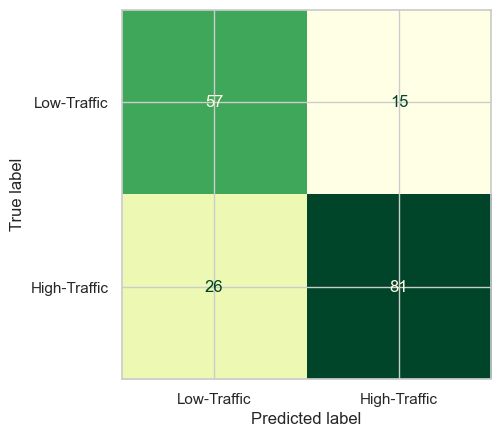

In [222]:
cm_rf = ConfusionMatrixDisplay.from_estimator(rf,
                                              X_test,
                                              y_test,
                                              display_labels=['Low-Traffic', 'High-Traffic'],
                                              cmap='YlGn',
                                              colorbar=False)
cm_rf.figure_.savefig('im/conf_rf.svg')

The results are similar to the ones obtained with the naive bayes model but there are more false negatives.

In [207]:
results = {'feature': features.columns,
           'importance': rf.best_estimator_.named_steps['randomforestclassifier'].feature_importances_}
importance = pd.DataFrame(results).sort_values(by='importance', ascending=False)
importance['feature'] = importance['feature'].str.replace('category_', '').str.title()
importance

,feature,importance
3,Protein,0.228334
13,Vegetable,0.215688
12,Potato,0.146860
11,Pork,0.091673
5,Breakfast,0.088274
1,Carbohydrate,0.056086
0,Calories,0.054382
6,Chicken,0.048686
2,Sugar,0.045991
4,Servings,0.007990


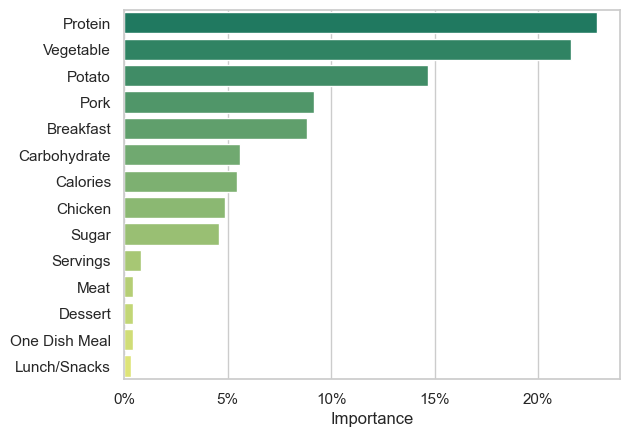

In [229]:
plot_importance = sns.barplot(x='importance', y='feature', data=importance, palette='summer')
plot_importance.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot_importance.set(xlabel = 'Importance',
                    ylabel='',
                    title='')
plot_importance.figure.savefig("im/importance.svg")

The most important features were Protein, Vegetable and Potato. Other categories like Lunch/Snacks, One Dish Meal, Dessert and Meal were not import.
The nutritional variables (carbohydrates, calories, sugar, protein) did not have a high importance, but protein results impressively relevant.

## Comparison

- The two models performed similarly.
- The naive bayes model had a better precision (85.29% vs 84.38%), which is the most important metric.
- The sensitivity was really similar (79.17%).
- Naive bayes is faster than random forest but the last should be reviewed in the future because it is a more complex model and hyperparameter tuning could improve it even more.
- Random forest did not need preprocessing, provide the most important variables, and it is easy to interpret. So **I would choose it as the best model**. At this stage I consider more important to detect the main drivers rather than the precision.
- However, I suggest to discuss with the team to decide if precision is paramount and then to choose Naive Bayes.

## Metric to monitor in the business

- The most important metric is precision because the business wants to correctly predict high-traffic recipes.
- With the current data a good starting point is 85%.
- The sensitivity must be regularly monitored because the business wants to avoid show low-traffic recipes in the main page of the website.
- More details about the strategy proposed to the business are in the conclusions.

# Conclusions
- Before continue, we need to check the data collection to properly treat missing values and outliers
- Vegetables are the most popular category, followed by potato. Recipes with four servings are the most popular. So, the business should focus on healthy recipes for families.
    - Have you considered clarifying your identity in the market? Perhaps advertising itself as a healthy family food company will help consolidate itself in this niche
- Recipes with high protein seem to be more decisive.
- Tasty Bytes should understand its customers better (i.e. collect more variables) to improve the model:
    - What are the main age groups?
    - People like new recipes every week or prefer that the current one be enhanced?

## Action plan
- Put the previous recommendations in practice
- To determine if the recommendations will help Tasty Bytes we should perform an AB test!
- Separate current customers into two groups:
    - To the first, we can continue to show them the current website.
    - To the second group, we show the website with the most healthy recipes for the family.
- Then, we measure the click-through rate (CTR) in each group.
- We can use the Bayesian techniques that I dominate to not only determine if there is a significant difference between the two groups, but also to quantify how strong it is!.
- In parallel, we should review the data collection process and try to obtain new features because the current ones were not enough: there is an opportunity for improvement!